In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pykrige.ok import OrdinaryKriging
from scipy import stats
from shapely.geometry import Point, LineString
import utm
import rasterio
from rasterio.transform import from_bounds
import ruptures as rpt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from math import ceil
import contextily as ctx

from regional_K.cpt_functions import setup_cpt, calc_SBT, soil_stress, detect_change_points, k_from_Ic, setup_grid, solve_Ic, SBT_from_Ic, ms_layer_assignment
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.decomposition import PCA

from ngl_tools import smt

import warnings
warnings.filterwarnings("ignore")

In [3]:
## setup cpt data 
cpt = setup_cpt('./USGS_CPT_data/')
## fill any missing water depths with the median
default_dGWT = np.nanmedian([cpt[bh]['Water depth'] for bh in cpt if not np.isnan(cpt[bh]['Water depth'])])
for bh in cpt:
    if np.isnan(cpt[bh]['Water depth']):
        cpt[bh]['Water depth'] = default_dGWT
cpt = soil_stress(cpt)
calc_SBT(cpt)

for _, data in cpt.items():
    data['CPT_data']['I_c'] = solve_Ic(data['CPT_data']['q_c'], data['CPT_data']['sig_v'],data['CPT_data']['sig_prime_v'], data['CPT_data']['f_s'])
    qt_inv, fs_inv, _ = smt.cpt_inverse_filter(np.array(data['CPT_data']['q_c']), np.array(data['CPT_data']['d']), fs=data['CPT_data']['f_s'], sigmav=data['CPT_data']['sig_v'], sigmavp=data['CPT_data']['sig_prime_v'])
    Ic_inv, _, _ = smt.get_Ic_Qtn_Fr(qt_inv, fs_inv, data['CPT_data']['sig_v'],data['CPT_data']['sig_prime_v'])
    data['CPT_data']['I_c_inv'] = Ic_inv
    data['SBT_inv'],_ = SBT_from_Ic(Ic_inv)
    data['k_fromIc_inv'] = k_from_Ic(Ic_inv)
    data['CPT_data']['k_fromIc'] = k_from_Ic(data['CPT_data']['I_c'])

shapefile_path = './deposits_shp/sfq2py.shp'
data = gpd.read_file(shapefile_path)
data.crs = 'EPSG:4326'
cpts_df = pd.DataFrame.from_dict(cpt, orient='index')
cpts_df.drop(['CPT_data'], axis=1, inplace=True)
cpts_gdf = gpd.GeoDataFrame(cpts_df, geometry=gpd.points_from_xy(cpts_df['Lon'], cpts_df['Lat']))
cpts_gdf.crs = 'EPSG:4326'
joined = gpd.sjoin(cpts_gdf, data, how='left')

cgs_data = pd.read_csv('./cgs_bhs_0/CGSBoreholeDB_BoreholeLocations.csv')
lith = pd.read_csv('./cgs_bhs_0/lithology.csv')
lith = lith[lith['remarks'].str.contains('fill', case=False, na=False)]
lith = lith.merge(cgs_data[['well_name', 'latitude', 'longitude']], on='well_name', how='left')
lith_gdf = gpd.GeoDataFrame(lith, geometry=gpd.points_from_xy(lith.longitude, lith.latitude),crs='EPSG:4326')
lith_gdf['Fill'] = lith_gdf['bottom_depth'] * 0.3048 # convert to meters
lith = lith[lith.index != 64] ## drop the 64 from the lith data index, it said 'filled' and was not artificial fill.
lith_gdf = lith_gdf[lith_gdf.index != 64]
lith_gdf['UTM -X'], lith_gdf['UTM -Y'] = zip(*[utm.from_latlon(lat, lon)[:2] for lat, lon in zip(lith_gdf['latitude'], lith_gdf['longitude'])])

points = setup_grid(geoplot='./geojson/alameda_city.geojson')  # run for just the cases on the island
points['utmX'] = pd.to_numeric(points['utmX'], errors='coerce')
points['utmY'] = pd.to_numeric(points['utmY'], errors='coerce')
points = points.dropna(subset=['utmX', 'utmY'])

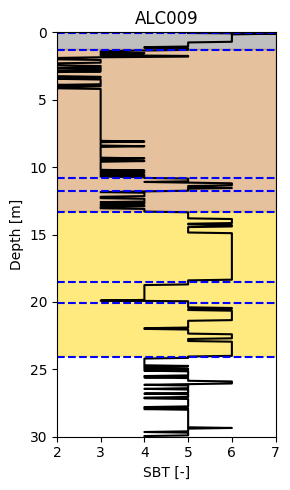

In [4]:
# assess what is happening at individual boreholes with a plot
# METHOD FOR THIS TEST IS CP with MS

preprocess = False
layers_dict = {}

# threshold1 = 0
# threshold2 = 24
# pen_0 = 0
# pen_1 = 20
# pen_2 = 40
a = 0
b = 20

for bh in ['ALC009']:##['ALC024','ALC026','ALC027','ALC021','ALC022','ALC032','ALC008']:
    df = cpt[bh]['CPT_data']
    depth = cpt[bh]['CPT_data']['d'].values
    fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0
    if preprocess:
        SBT = cpt[bh]['SBT_inv']
        logKh = np.log(cpt[bh]['k_fromIc_inv']*86400).clip(-5)
    else:
        SBT = cpt[bh]['SBT']
        logKh = np.log(df['k_fromIc']*86400).clip(-5)
    change_points = detect_change_points(SBT, model="l2", penalty=a*(max(cpt[bh]['CPT_data']['d']) -12) + b)[:-1]
    change_points = [0] + change_points + [len(cpt[bh]['CPT_data']['d']) - 1]
    depths = []
    Ks = []
    SBTs = []
    for cp_ind in range(len(change_points) - 1):
        start_idx = change_points[cp_ind]
        end_idx = change_points[cp_ind + 1]

        avg_k_fromIc = cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean()
        avg_SBT = stats.mode(cpt[bh]['SBT'][start_idx:end_idx])[0]  # here also ['CPT_data'] for corrected data
        start_depth = cpt[bh]['CPT_data']['d'][start_idx]
        end_depth = cpt[bh]['CPT_data']['d'][end_idx]
        SBTs.append(avg_SBT)
        depths.append(end_depth - start_depth)
        Ks.append(avg_k_fromIc)
    ## now assign layers using MS method
    layers_dict[bh] = ms_layer_assignment(depths, SBTs, fill_flag)
    minx= 2
    maxx= 7
    fig, ax = plt.subplots(figsize=(3,5))
    if preprocess:
        ax.plot(cpt[bh]['SBT_inv'], cpt[bh]['CPT_data']['d'],'k')
    else:
        ax.plot(cpt[bh]['SBT'], cpt[bh]['CPT_data']['d'],'k')
    ax.fill_between([minx,maxx],0, layers_dict[bh]['Fill'], color='grey', alpha=0.5)
    ax.fill_between([minx,maxx],layers_dict[bh]['Fill'], layers_dict[bh]['Fill'] + layers_dict[bh]['Young Bay Mud'], color='peru', alpha=0.5)
    ax.fill_between([minx,maxx],layers_dict[bh]['Fill'] + layers_dict[bh]['Young Bay Mud'], layers_dict[bh]['Fill'] + layers_dict[bh]['Young Bay Mud'] + layers_dict[bh]['Merritt Sand'], color='gold', alpha=0.5)
    for cp in change_points:
        ax.axhline(y=cpt[bh]['CPT_data']['d'][cp], color='b', linestyle='--')

    # ax.axhline(y=bh_layers[bh][tref]['Fill'], color='g', linestyle='--')
    # ax.axhline(y=bh_layers[bh][tref]['Fill'] + bh_layers[bh][tref]['Young Bay Mud'], color='brown', linestyle='--')
    # ax.axhline(y=bh_layers[bh][tref]['Fill'] + bh_layers[bh][tref]['Young Bay Mud'] + bh_layers[bh][tref]['Merritt Sand'], color='orange', linestyle='--')
    ax.set_ylim(30,0)
    # ax.set_xscale('log')
    plt.title(bh)
    ax.set_xlim(2,7)
    ax.set_xlabel('SBT [-]')
    ax.set_ylabel('Depth [m]')
    fig.tight_layout()



#### This section is to compare layer thicknesses with borehole depths for different penalties


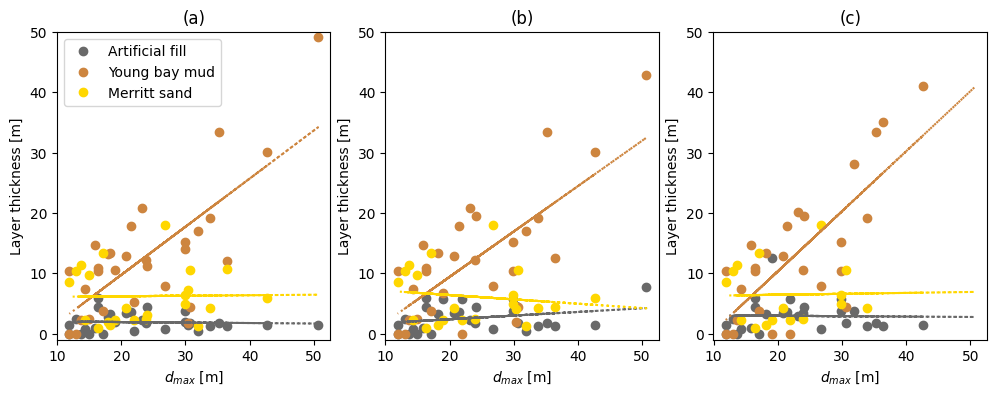

In [31]:
# assess what is happening at individual boreholes with a plot
# METHOD FOR THIS TEST IS CP with MS
preprocess = False
layers_dict = {}

## try constant penalty and also ax + b where b = 20 and x = max(d) - 12, a is 1 or 2
a = 0
b = 20
sublabel = ['(a)','(b)','(c)']
# for a in [0,1,2]:
fig,axes=plt.subplots(1,3,figsize=(12,4))
# for i,(ax,b) in enumerate(zip(axes,[14,20,26])):
for i,(ax,a) in enumerate(zip(axes,[0,1,2])):
    x_d = []
    y_d = []
    t_d = []
    t_mud =[]
    t_fill = []
    t_ms = []
    for bh in cpt:
        df = cpt[bh]['CPT_data']
        depth = cpt[bh]['CPT_data']['d'].values
        fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0
        if preprocess:
            SBT = cpt[bh]['SBT_inv']
            logKh = np.log(cpt[bh]['k_fromIc_inv']*86400).clip(-5)
        else:
            SBT = cpt[bh]['SBT']
            logKh = np.log(df['k_fromIc']*86400).clip(-5)

        change_points = detect_change_points(SBT, model="l2", penalty=a*(max(cpt[bh]['CPT_data']['d']) -12) + b)[:-1]
        change_points = [0] + change_points + [len(cpt[bh]['CPT_data']['d']) - 1]
        depths = []
        Ks = []
        SBTs = []
        for cp_ind in range(len(change_points) - 1):
            start_idx = change_points[cp_ind]
            end_idx = change_points[cp_ind + 1]

            avg_k_fromIc = cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean()
            avg_SBT = stats.mode(cpt[bh]['SBT'][start_idx:end_idx])[0]  # here also ['CPT_data'] for corrected data
            start_depth = cpt[bh]['CPT_data']['d'][start_idx]
            end_depth = cpt[bh]['CPT_data']['d'][end_idx]
            SBTs.append(avg_SBT)
            depths.append(end_depth - start_depth)
            Ks.append(avg_k_fromIc)
        ## now assign layers using MS method
        layers_dict[bh] = ms_layer_assignment(depths, SBTs, fill_flag)

        x_d.append(max(depth))
        y_d.append(np.mean(depths))  # this is the depths from the CPs, not layers
        t_d.append((layers_dict[bh]['Fill'] + layers_dict[bh]['Young Bay Mud'] + layers_dict[bh]['Merritt Sand'])/3)
        t_mud.append(layers_dict[bh]['Young Bay Mud'])
        t_fill.append(layers_dict[bh]['Fill'])
        t_ms.append(layers_dict[bh]['Merritt Sand'])
    t_d = np.array(t_d)
    t_mud = np.array(t_mud)
    t_fill = np.array(t_fill)
    t_ms = np.array(t_ms)
    x_d = np.array(x_d)

    ax.plot(x_d, t_fill, 'o', color='dimgrey')
    ax.plot(x_d, t_mud, 'o', color='peru')
    ax.plot(x_d, t_ms, 'o', color='gold')
    if i == 0:
        ax.legend(['Artificial fill','Young bay mud','Merritt sand'])
    z = np.polyfit(x_d[~np.isnan(t_fill)], t_fill[~np.isnan(t_fill)], 1)
    p = np.poly1d(z)
    ax.plot(x_d,p(x_d),":",color='dimgrey')
    z = np.polyfit(x_d[~np.isnan(t_mud)], t_mud[~np.isnan(t_mud)], 1)
    p = np.poly1d(z)
    ax.plot(x_d,p(x_d),":",color='peru')
    z = np.polyfit(x_d[~np.isnan(t_ms)], t_ms[~np.isnan(t_ms)], 1)
    p = np.poly1d(z)
    ax.plot(x_d,p(x_d),":",color='gold')
    ax.set_xlabel('$d_{max}$ [m]')
    ax.set_ylabel('Layer thickness [m]')
    ax.set_ylim([-1,50])
    # ax.set_title('$\lambda = $'+str(a) + '$(d_{max}-12) + $'+str(b))
    ax.set_title(sublabel[i])
plt.savefig('./figures/deposit_depths_CP_a.png',format='png',dpi=1000,bbox_inches='tight')
plt.savefig('./figures/deposit_depths_CP_a.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

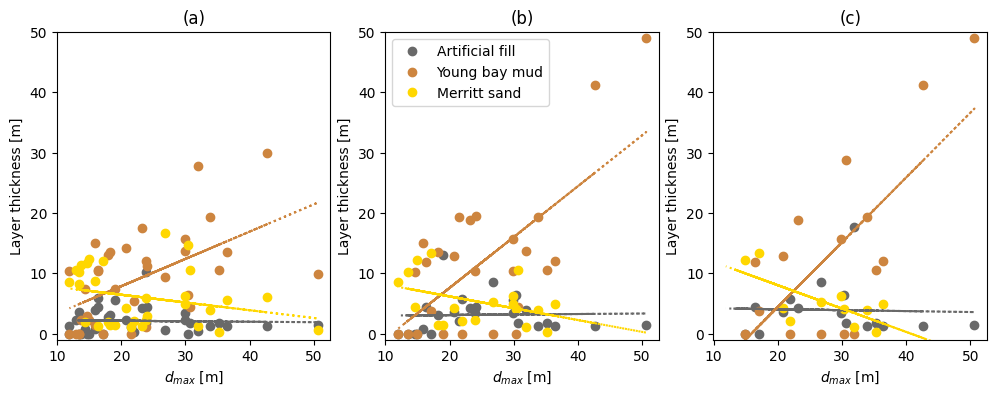

In [30]:
# run the same comparison using smt and t_ref of 3,6,9

# assess what is happening at individual boreholes with a plot
# METHOD FOR THIS TEST IS CP with MS
preprocess = False
layers_dict = {}

# make a 1x3 subfigure to fill in the loop
fig,axes = plt.subplots(1,3,figsize=(12,4))
trefs=[3,6,9]
for i, (ax,t_ref) in enumerate(zip(axes.flatten(),trefs)):
    x_d = []
    y_d = []
    t_d = []
    t_mud =[]
    t_fill = []
    t_ms = []
    for bh in cpt:
        df = cpt[bh]['CPT_data']
        depth = cpt[bh]['CPT_data']['d'].values
        fill_flag = 1 if joined.loc[bh]['PTYPE'] in ['afem','H2O'] else 0
        if preprocess:
            SBT = cpt[bh]['SBT_inv']
            logKh = np.log(cpt[bh]['k_fromIc_inv']*86400).clip(-5)
        else:
            SBT = cpt[bh]['SBT']
            logKh = np.log(df['k_fromIc']*86400).clip(-5)

        ztop, zbot, _, _ = smt.cpt_layering(np.array(SBT), np.array(logKh), depth, tref=t_ref, Nmax=None)
        SBTs = []
        Ks = []
        for indx in range(len(ztop)):
            start_idx = np.where(depth >= ztop[indx])[0][0]
            end_idx = np.where(depth >= zbot[indx])[0][0]
            SBTs.append(stats.mode(cpt[bh]['SBT'][start_idx:end_idx])[0])
            Ks.append(cpt[bh]['CPT_data']['k_fromIc'][start_idx:end_idx].mean())
        
    
        depths = zbot - ztop
        layers_dict[bh] = ms_layer_assignment(depths, SBTs, fill_flag)
        layers_dict[bh]['UTM -X'] = cpt[bh]['UTM-X']
        layers_dict[bh]['UTM -Y'] = cpt[bh]['UTM-Y']

        x_d.append(max(depth))
        y_d.append(np.mean(depths))  # this is the depths from the CPs, not layers
        t_d.append((layers_dict[bh]['Fill'] + layers_dict[bh]['Young Bay Mud'] + layers_dict[bh]['Merritt Sand'])/3)
        t_mud.append(layers_dict[bh]['Young Bay Mud'])
        t_fill.append(layers_dict[bh]['Fill'])
        t_ms.append(layers_dict[bh]['Merritt Sand'])

    t_d = np.array(t_d)
    t_mud = np.array(t_mud)
    t_fill = np.array(t_fill)
    t_ms = np.array(t_ms)
    x_d = np.array(x_d)

    # plt.plot(x_d, y_d, 'o')
    ax.plot(x_d, t_fill, 'o', color='dimgrey')
    ax.plot(x_d, t_mud, 'o', color='peru')
    ax.plot(x_d, t_ms, 'o', color='gold')
    if i == 1:
        ax.legend(['Artificial fill','Young bay mud','Merritt sand'])
    # add trendlines
    z = np.polyfit(x_d[~np.isnan(t_fill)], t_fill[~np.isnan(t_fill)], 1)
    p = np.poly1d(z)
    ax.plot(x_d,p(x_d),":",color='dimgrey')
    z = np.polyfit(x_d[~np.isnan(t_mud)], t_mud[~np.isnan(t_mud)], 1)
    p = np.poly1d(z)
    ax.plot(x_d,p(x_d),":",color='peru')
    z = np.polyfit(x_d[~np.isnan(t_ms)], t_ms[~np.isnan(t_ms)], 1)
    p = np.poly1d(z)
    ax.plot(x_d,p(x_d),":",color='gold')
    ax.set_xlabel('$d_{max}$ [m]')
    ax.set_ylabel('Layer thickness [m]')
    ax.set_ylim([-1,50])
    # ax.set_title('$t_{ref} = $' + str(t_ref))
    ax.set_title(sublabel[i])
plt.savefig('./figures/deposit_depths_cluster.png',format='png',dpi=1000,bbox_inches='tight')
plt.savefig('./figures/deposit_depths_cluster.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

In [38]:
t_ms

array([['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand'],
       ['Merrit sand']], dtype='<U11')

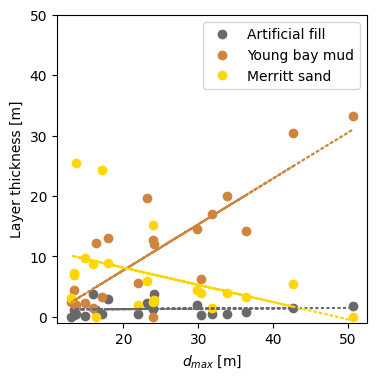

In [39]:
# make a plot like the above with heuristic data

layers = pd.read_csv('./layer_thicknesses.csv', index_col=0)
t_mud =[]
t_fill = []
t_ms = []
x_d = []
for _,row in layers.iterrows():  # [layers['Filename'].str.startswith('ALC')]
## only run if the Filename is in cpt
    if row['Filename'] in cpt:
        t_fill.append(row['Fill'])
        t_mud.append(row['Young Bay Mud'])
        t_ms.append(row['Merrit sand'])
        x_d.append(cpt[row['Filename']]['CPT_data']['d'].max())
    else:
        continue

t_fill = np.array(t_fill)
t_mud = np.array(t_mud)
t_ms = np.array(t_ms)
x_d = np.array(x_d)

fig,ax = plt.subplots(figsize=(4,4))
ax.plot(x_d, t_fill, 'o', color='dimgrey')
ax.plot(x_d, t_mud, 'o', color='peru')
ax.plot(x_d, t_ms, 'o', color='gold')
ax.legend(['Artificial fill','Young bay mud','Merritt sand'])
z = np.polyfit(x_d[~np.isnan(t_fill)], t_fill[~np.isnan(t_fill)], 1)
p = np.poly1d(z)
ax.plot(x_d,p(x_d),":",color='dimgrey')
z = np.polyfit(x_d[~np.isnan(t_mud)], t_mud[~np.isnan(t_mud)], 1)
p = np.poly1d(z)
ax.plot(x_d,p(x_d),":",color='peru')
z = np.polyfit(x_d[~np.isnan(t_ms)], t_ms[~np.isnan(t_ms)], 1)
p = np.poly1d(z)
ax.plot(x_d,p(x_d),":",color='gold')
ax.set_xlabel('$d_{max}$ [m]')
ax.set_ylabel('Layer thickness [m]')
ax.set_ylim([-1,50])
plt.savefig('./figures/deposit_depths_heuristic.png',format='png',dpi=1000,bbox_inches='tight')
plt.savefig('./figures/deposit_depths_heuristic.pdf',format='pdf',dpi=1000,bbox_inches='tight')
